In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter 

## Data Processing

In [2]:
class AnnotationProcessor:
    def __init__(self, base_path, output_path='/kaggle/working/', filename='dataset.csv'):
        self.base_path = base_path
        self.output_path = output_path
        self.filename = filename
        self.data = None
        self.run()

    def get_group_annotation(self, file, folder_name):
        """Extract the first two elements from each row of the annotation file."""
        with open(file, 'r') as f:
            data = [line.split()[:2] for line in f]

        df = pd.DataFrame(data, columns=['FrameID', 'Label'])
        df['video_names'] = folder_name
## ['l-spike', 'l_set', 'r_set', 'r-pass', 'r_spike', 'l-pass',
       #'r_winpoint', 'l_winpoint']
        label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}
        df['Mapped_Label'] = df['Label'].map(label_mapping).astype('int64')
        # Ensure the output directory exists
        os.makedirs(self.output_path, exist_ok=True)
        # Save the file directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, f'{folder_name}.csv'), index=False)

    def process_annotations(self):
        """Process annotations from all folders in the base path."""
        for folder_name in os.listdir(self.base_path):
            folder_path = os.path.join(self.base_path, folder_name)
            if os.path.isdir(folder_path):
                annotated_file_path = os.path.join(folder_path, 'annotations.txt')
                self.get_group_annotation(annotated_file_path, folder_name)

    def combine_csv_files(self):
        """Combine all CSV files into a single DataFrame."""
        csv_files = glob.glob(os.path.join(self.output_path, '*.csv'))
        data = [pd.read_csv(csv_file) for csv_file in csv_files]
        for d in data:
            d.dropna(inplace=True)
            # print(d.isna().sum())
        return pd.concat(data, ignore_index=True)

    def generate_img_paths(self, df):
        """Generate image paths based on the DataFrame."""
        df['img_path'] = df.apply(
            lambda x: os.path.join(
                self.base_path,
                str(x['video_names']),  # Ensure `video_names` is a string
                str(x['FrameID'])[:-4],  # Ensure `FrameID` is a string and remove the last 4 characters
                str(x['FrameID'])  # Ensure `FrameID` is a string
            ), axis=1
        )
        return df

    def save_combined_data(self, df):
        """Save the combined data to a CSV file."""
        # Ensure the output directory exists before saving
        os.makedirs(self.output_path, exist_ok=True)
        # Save the combined data directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, self.filename), index=False)

    def cleanup(self):
        """Delete all intermediate CSV files except the final output file."""
        for csv_file in glob.glob(os.path.join(self.output_path, '*.csv')):
            if not csv_file.endswith(self.filename):
                os.remove(csv_file)

    def run(self):
        """Run the whole annotation processing pipeline."""
        self.process_annotations()
        combined_data = self.combine_csv_files()
        data_with_paths = self.generate_img_paths(combined_data)
        self.save_combined_data(data_with_paths)
        self.cleanup()  # Clean up intermediate files
        self.data = pd.read_csv(os.path.join(self.output_path, self.filename))


Make sure you want to run this before running it

In [3]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [4]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = AnnotationProcessor(base_path, 'dataset.csv').data

## Model

In [5]:
class ResnetEvolution(nn.Module):
    def __init__(self, hidden_layers=[128, 64, 32]):
        super(ResnetEvolution, self).__init__()
        self.hidden_layers = hidden_layers
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features

        layers = []
        input_size = num_features  # Start with backbone output size
        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            input_size = hidden_size  # Update input for next layer

        layers.append(nn.Linear(input_size, 8))  # Final output layer

        backbone.fc = nn.Sequential(*layers)  # Output layer for binary classification

        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Trainer

In [6]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, criterion, epochs, dataloaders, device, save_folder, is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint

    #verbose 1 : checkpoint,
    #verbose 3:  labels, preds
    #verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders

        epoch = 0
        if self.is_continue:

            if verbose>0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            # print(f"\nTraining epoch {training_epoch}: training {'full model' if self.__check_transfer_learning(training_epoch/epochs) else 'only fc model'}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    model.train()
                    for inputs, labels in tqdm(dataloader, desc=phase):

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        # forward pass
                        logit = model(inputs)

                        if verbose > 3:
                            print(f"logit: {logit}")

                        loss = criterion(logit, labels)
                        loss.backward()
                        # update weights
                        optimizer.step()
                        epoch_loss += loss.item()  # Accumulate loss
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    print(f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss


            self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(), verbose)

        self.__save_model(verbose)

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs = inputs.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                if verbose > 2:
                    print(f"labels: {labels}")

                # Forward pass
                logits = model(inputs)

                if verbose > 3:
                    print(f"logit: {logits}")

                probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                if verbose > 3:
                    print(f"probs: {probs}")

                loss = criterion(logits, labels)
                val_loss += loss.item()  # Accumulate loss

                # Compute accuracy
                predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                if verbose > 2:
                    print(f"predicted: {predicted}")
                    print(f"true/false: {(predicted == labels)}")

                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

    def __save_model(self, verbose=0):
        torch.save(self.model.state_dict(), self.save_folder + "/b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {self.save_folder}/b1_model.pth")

    def __save_checkpoint(self, epoch, model_state_dict, optimizer_state_dict, verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
        }
        torch.save(checkpoint, self.save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {self.save_folder}/checkpoint-epoch{epoch}.pth')

    def __load_checkpoint(self, model, optimizer, checkpoint_path, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        model = model.load_state_dict(model_state_dict)
        optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Dataset

In [7]:
class B1Dataset(Dataset):

    VIDEO_SPLITS = {
        'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
        'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
        'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
    }

    def __init__(self, csv_file, split='train', transform=None):
        self.data = pd.read_csv(csv_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        if split in self.VIDEO_SPLITS:
            self.data = self.data[self.data['video_names'].astype(int).isin(self.VIDEO_SPLITS[split])]
        else:
            raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['img_path']
        label = self.data.iloc[idx]['Mapped_Label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

## Loss

In [8]:
class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, dataset, device):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.dataset = dataset
        self.device = device
        weight = self.__compute_weights()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def __compute_weights(self):
        print('Computing weights...')
        label_counts = Counter([label.item() for _, label in self.dataset])
        total_samples = len(self.dataset)

        class_weights = [total_samples / label_counts[i] if i in label_counts else 0 for i in range(8)]

        weights = torch.tensor(class_weights, dtype=torch.float32).to(self.device)
        print('Weights computed.')
        return weights

    def forward(self, logit, target):
        return self.loss(logit, target)

## Code

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256     
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomRotation(degrees=5),                   # Randomly rotate images within ±5 degrees
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='train', transform=train_transform)
val_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='val')

In [11]:
batch_size = 150
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

In [12]:
!mkdir '/kaggle/working/checkpoints/'

In [13]:
model = ResnetEvolution(hidden_layers=[])
model = model.to(device)
criterion = WeightedCrossEntropyLoss(train_dataset, device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer, criterion, epochs=20, dataloaders=dataloaders, device=device, save_folder=save_folder)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Computing weights...
Weights computed.


In [14]:
trainer.train_model()

train: 100%|██████████| 15/15 [00:48<00:00,  3.22s/it]


Epoch 1/20, train Loss: 2.0785641352335613


Evaluating: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Epoch 1/20, (val) Loss: 2.0674043231540256 | Accuracy: 0.13497390007457122


train: 100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


Epoch 2/20, train Loss: 2.0426318009694415


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 2/20, (val) Loss: 2.029342850049337 | Accuracy: 0.16554809843400448


train: 100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


Epoch 3/20, train Loss: 1.9779555320739746


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


Epoch 3/20, (val) Loss: 1.9151882992850409 | Accuracy: 0.2140193885160328


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 4/20, train Loss: 1.8052271366119386


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 4/20, (val) Loss: 1.806200663248698 | Accuracy: 0.2803877703206562


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 5/20, train Loss: 1.6094733794530234


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.33s/it]


Epoch 5/20, (val) Loss: 1.495038284195794 | Accuracy: 0.4064131245339299


train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 6/20, train Loss: 1.370809809366862


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.33s/it]


Epoch 6/20, (val) Loss: 1.3007512489954631 | Accuracy: 0.47054436987322895


train: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Epoch 7/20, train Loss: 1.209070626894633


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.33s/it]


Epoch 7/20, (val) Loss: 1.1848203076256647 | Accuracy: 0.5331841909023117


train: 100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


Epoch 8/20, train Loss: 1.0877830465634664


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 8/20, (val) Loss: 1.1719024578730266 | Accuracy: 0.5294556301267711


train: 100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


Epoch 9/20, train Loss: 1.0177546977996825


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


Epoch 9/20, (val) Loss: 1.4252681069903903 | Accuracy: 0.4854586129753915


train: 100%|██████████| 15/15 [00:47<00:00,  3.16s/it]


Epoch 10/20, train Loss: 0.9384734471638997


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]


Epoch 10/20, (val) Loss: 1.1094464394781325 | Accuracy: 0.5749440715883669


train: 100%|██████████| 15/15 [00:46<00:00,  3.13s/it]


Epoch 11/20, train Loss: 0.9095480084419251


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]


Epoch 11/20, (val) Loss: 1.057681918144226 | Accuracy: 0.5913497390007457


train: 100%|██████████| 15/15 [00:46<00:00,  3.11s/it]


Epoch 12/20, train Loss: 0.8531262199083964


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]


Epoch 12/20, (val) Loss: 1.0710962149831984 | Accuracy: 0.6040268456375839


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 13/20, train Loss: 0.8148341337839763


Evaluating: 100%|██████████| 9/9 [00:22<00:00,  2.45s/it]


Epoch 13/20, (val) Loss: 0.9368356068929037 | Accuracy: 0.6465324384787472


train: 100%|██████████| 15/15 [00:48<00:00,  3.20s/it]


Epoch 14/20, train Loss: 0.7766020933787028


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.34s/it]


Epoch 14/20, (val) Loss: 1.0465383860800002 | Accuracy: 0.609992542878449


train: 100%|██████████| 15/15 [00:48<00:00,  3.21s/it]


Epoch 15/20, train Loss: 0.751395050684611


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]


Epoch 15/20, (val) Loss: 0.9883498350779215 | Accuracy: 0.6301267710663684


train: 100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


Epoch 16/20, train Loss: 0.7373811443646748


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]


Epoch 16/20, (val) Loss: 0.959773494137658 | Accuracy: 0.6368381804623415


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 17/20, train Loss: 0.7165668447812398


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Epoch 17/20, (val) Loss: 1.043320013417138 | Accuracy: 0.6375838926174496


train: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


Epoch 18/20, train Loss: 0.6847040096918742


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Epoch 18/20, (val) Loss: 0.9434706767400106 | Accuracy: 0.6360924683072334


train: 100%|██████████| 15/15 [00:47<00:00,  3.17s/it]


Epoch 19/20, train Loss: 0.6558235446612041


Evaluating: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]


Epoch 19/20, (val) Loss: 0.9883654382493761 | Accuracy: 0.6249067859806114


train: 100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


Epoch 20/20, train Loss: 0.6043578227361043


Evaluating: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


Epoch 20/20, (val) Loss: 0.9552236066924201 | Accuracy: 0.6480238627889635


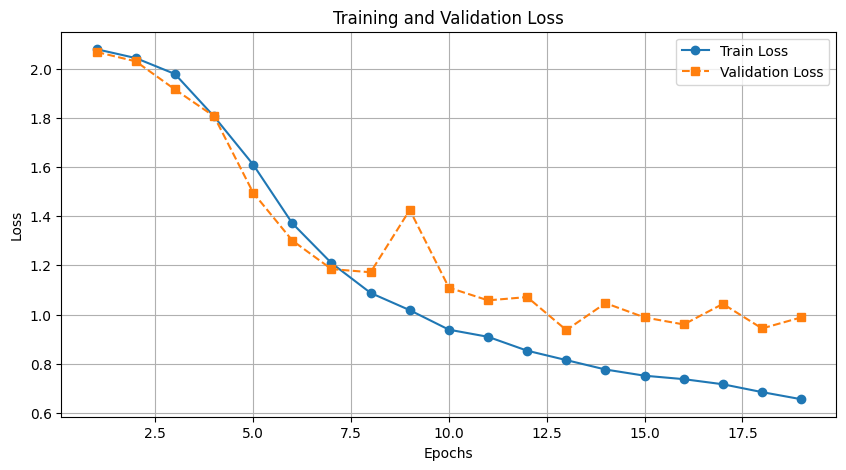

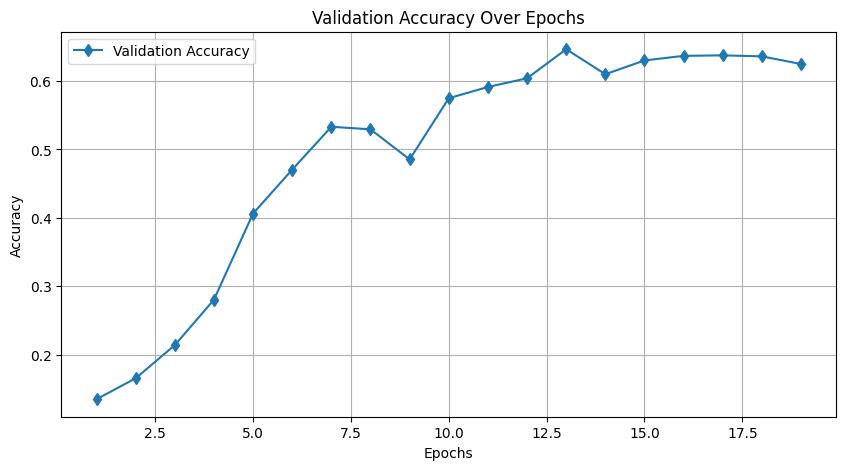

In [16]:
import matplotlib.pyplot as plt

# Data extracted from the log
epochs = list(range(1, 21))
train_loss = [
    2.0786, 2.0426, 1.9780, 1.8052, 1.6095, 1.3708, 1.2091, 1.0878, 1.0178, 0.9385,
    0.9095, 0.8531, 0.8148, 0.7766, 0.7514, 0.7374, 0.7166, 0.6847, 0.6558
]
val_loss = [
    2.0674, 2.0293, 1.9152, 1.8062, 1.4950, 1.3008, 1.1848, 1.1719, 1.4253, 1.1094,
    1.0577, 1.0711, 0.9368, 1.0465, 0.9883, 0.9598, 1.0433, 0.9435, 0.9884
]
val_accuracy = [
    0.13497, 0.16555, 0.21402, 0.28039, 0.40641, 0.47054, 0.53318, 0.52946, 0.48546, 0.57494,
    0.59135, 0.60403, 0.64653, 0.60999, 0.63013, 0.63684, 0.63758, 0.63609, 0.62491
]

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs[:19], train_loss, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs[:19], val_loss, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs[:19], val_accuracy, label="Validation Accuracy", marker="d", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
